# ДЗ1. CLAP. Обучение проекции из аудио в текстовое пространство CLIP

**Описание задания**

В этом задании вы построите упрощённый вариант модели CLAP (Contrastive Language-Audio Pretraining):

- аудио прогоняется через предобученный аудио-энкодер (например, `LanguageBindAudio`, `CNN14/16` или другой);
- текстовое описание пропускается через предобученный текстовый энкодер CLIP;
- поверх аудио-векторов обучается линейный адаптер, который отображает аудио в то же пространство, что и текстовые эмбеддинги CLIP;
- обучение идёт по *контрастивному лоссу*, все энкодеры заморожены, обучаются только параметры аудио-проекции (и, при желании, температура в лоссе);
- качество полученного аудио-текстового пространства оценивается на задаче классификации / retrieval аудио по текстам на `AudioCaps`.

Идея оценки: если всё сделано правильно, для аудио и его описания косинусное сходство эмбеддингов будет выше, чем для аудио и нерелевантных текстов.


**Формулировка задач**

0. Выбор аудио-энкодера.
   Выберите и обоснуйте предобученный аудио-энбеддер:  
   - `LanguageBindAudio`,  
   - или CNN-модель (например, PANNs CNN14/16),  
   - или другой открытый аудио-энкодер, который выдаёт фиксированный эмбеддинг.

1. Подсчёт эмбеддингов.
   - Посчитайте аудио-векторы для всех аудио из `AudioCaps` с помощью выбранного энкодера.  
   - Посчитайте текстовые векторы для подписей с помощью `CLIP text encoder`.

2. Линейная аудио-проекция.
   - Реализуйте модель `AudioProjection`, переводящую аудио-эмбеддинг в размерность текстового эмбеддинга CLIP.

3. Контрастивное обучение.
   - Обучите аудио-проекцию на датасете `AudioCaps` по схеме аудио ↔ текст с контрастивным лоссом.  
   - Аудио-энкодер и CLIP должны быть полностью заморожены.

4. Оценка качества.
   - Оцените качество полученного аудио-текстового пространства на задаче классификации/ретривала аудио:  
     для каждого аудио найдите наиболее похожую текстовую подпись в батче/валидации и посчитайте `accuracy@1/3/10`.  
   - Сравните результаты с *случайным бейзлайном*.


### Сеттинг

> Подготовьте все необходимые импорты и загрузите необходимые данные.

In [1]:
!pip install -q panns-inference

In [2]:
import copy
import os
from itertools import batched
import json
import random
import kagglehub
import pandas as pd
import numpy as np
import librosa as lb
from transformers import CLIPTokenizer, CLIPTextModel
from panns_inference import AudioTagging
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')

os.environ['KAGGLEHUB_CACHE'] = '/content'

Mounted at /content/drive


In [ ]:
DATA_ROOT = kagglehub.dataset_download('nickkar30/audiocaps')
print('Files in DATA_ROOT:', os.listdir(DATA_ROOT))

100%|██████████| 9.67G/9.67G [05:42<00:00, 30.3MB/s]

Extracting files...


Files in DATA_ROOT: ['audiocaps']


### Задание 1. Подготовка аудио- и текстовых энкодеров (2 балла)

В этом задании вам нужно:

1. Выбрать аудио-энкодер и инициализировать его.
2. Инициализировать текстовый энкодер CLIP. Вы свободны выбирать самостоятельно, какой имеено.
3. Заморозить параметры обоих энкодеров (мы не дообучаем их, а учим только линейный адаптер).

Вы можете:

* использовать `LanguageBindAudio` (потребует установки репозитория и зависимостей);
* или подставить свою аудио-модель (главное - чтобы на выходе был вектор фиксированной размерности).


In [ ]:
# your code here
# ┌(ಠ_ಠ)┘

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
audio_encoder = AudioTagging(checkpoint_path=None, device=str(device))

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [5]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')
text_encoder.eval()
text_encoder.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

### Задание 2. Предподсчёт аудио- и текстовых эмбеддингов (3 балла)

> Важный момент, который пригодится вам и в других домашних.

Чтобы не тратить время на многократный прогон энкодеров при обучении, следует:

1. Предварительно посчитывать аудио-эмбеддинги для каждого `.flac` в train/val/test.
2. Записывать их в файл формата `pickle` (например), где ключ - имя файла, значение - numpy-вектор.
3. Аналогично посчитать текстовые эмбеддинги для подписей через CLIP и совместить их с аудио.

Рекомендуемая структура:

* функция `extract_audio_vectors_with_checkpointing(...)` - обходит файлы, считает эмбеддинги, периодически делает чекпоинты;
* функция `extract_text_embeddings(texts, clip_model, clip_processor)` - возвращает список текстовых эмбеддингов;
* функция `process_dataset(...)` - читает `.tsv`, мержит аудио-эмбеддинги и текстовые, сохраняет список словарей вида  
  `{"uniq_id": ..., "audio_embedding": ..., "text_embedding": ...}` в pickle.

> Вы вольны отходить от предлагаемой структуры.

In [ ]:
# your code here (づ｡◕‿‿◕｡)づ

In [ ]:
def encode_audio(audios, audio_encoder, sampling_rate):
    max_len = max(len(a) for a in audios)
    padded_audios = np.array([np.pad(a, (0, max_len - len(a))) for a in audios])

    _, embeddings = audio_encoder.inference(padded_audios)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=-1, keepdims=True)
    embeddings = embeddings.tolist()

    del max_len
    del _
    del padded_audios

    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    return embeddings


def extract_text_embeddings(texts, clip_model, tokenizer):
    inputs = tokenizer(
        texts, padding=True, truncation=True, return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        embeddings = outputs.pooler_output
        embeddings = F.normalize(embeddings, p=2, dim=1)

    embeddings = embeddings.tolist()

    del outputs
    del inputs
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    return embeddings


def load_audio_to_numpy(path):
    return lb.load(path, sr=None)


def process_dataset(dataset_path, output_file):
    data = pd.read_csv(dataset_path, sep='\t').to_dict(orient='records')
    sampling_rate = None

    for batch in tqdm(list(batched(data, n=16))):
        uniq_ids = [record['uniq_id'] for record in batch]

        audios = [load_audio_to_numpy(f"{DATA_ROOT}/{record['audio']}") for record in batch]
        sampling_rate = sampling_rate or audios[0][1]
        audios = [audio[0] for audio in audios if audio[1] == sampling_rate]
        audio_embeddings = encode_audio(audios, audio_encoder, sampling_rate)

        text_embeddings = extract_text_embeddings([record['text'] for record in batch], text_encoder, tokenizer)

        batch_items = []
        for uniq_id, audio_embedding, text_embedding in zip(uniq_ids, audio_embeddings, text_embeddings):
            batch_items.append({
                'uniq_id': uniq_id,
                'audio_embedding': audio_embedding,
                'text_embedding': text_embedding,
            })

        os.makedirs(os.path.dirname(output_file), exist_ok=True)

        with open(output_file, 'a', encoding='utf8') as fout:
            for item in batch_items:
                fout.write(json.dumps(item) + '\n')

In [ ]:
process_dataset(f'{DATA_ROOT}/audiocaps/audiocaps_val_new.tsv', '/content/drive/MyDrive/multimodal_AI/hw1/val.jsonl')

  0%|          | 0/31 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


In [ ]:
process_dataset(f'{DATA_ROOT}/audiocaps/audiocaps_test_new.tsv', '/content/drive/MyDrive/multimodal_AI/hw1/test.jsonl')

100%|██████████| 61/61 [00:11<00:00,  5.53it/s]


In [ ]:
process_dataset(f'{DATA_ROOT}/audiocaps/audiocaps_train.tsv', '/content/drive/MyDrive/multimodal_AI/hw1/train.jsonl')

100%|██████████| 3094/3094 [09:52<00:00,  5.22it/s]


### Задание 3. Линейный аудио-адаптер и контрастивный лосс (3 балла)


Теперь, когда у нас есть пары *audio_embedding, text_embedding*, реализуем:

1. Класс `AudioTextDataset`, который читает pickle с комбинированными эмбеддингами.
2. Линейную модель `AudioProjection`, переводящую аудио-эмбеддинг в размерность текстового.
3. Контрастивный лосс для аудио↔текст:
   - нормализовать эмбеддинги по L2;
   - посчитать матрицу сходства;
   - задать таргеты как `targets = arange(batch_size)`;
   - вычислить `CrossEntropyLoss` как для строк audio→text и для строк text→audio, усреднить.

Обучаем **только** `AudioProjection` (и, по желанию, параметр temperature).


In [ ]:
# your code here
# (╯°□°）╯︵ ┻━┻

In [6]:
class AudioTextDataset(Dataset):
    def __init__(self, file_path) -> None:
        self.data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_embedding = torch.tensor(self.data[idx]['audio_embedding'], dtype=torch.float)
        text_embedding = torch.tensor(self.data[idx]['text_embedding'], dtype=torch.float)
        return audio_embedding, text_embedding

In [7]:
class ProjectionModule(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )

    def forward(self, embeddings):
        return self.projection(embeddings)

In [8]:
class SigLipLoss(nn.Module):
    def __init__(self, init_t=10, init_b=-10.0):
        super().__init__()
        self.t_prime = nn.Parameter(torch.tensor(np.log(init_t)))
        self.b = nn.Parameter(torch.tensor(float(init_b)))

    def forward(self, audio_embeddings, text_embeddings):
        n = audio_embeddings.size(0)

        za = F.normalize(audio_embeddings, p=2, dim=1)
        zt = F.normalize(text_embeddings, p=2, dim=1)

        t = torch.exp(self.t_prime)

        logits = (za @ zt.T) * t + self.b
        labels = (2 * torch.eye(n, dtype=logits.dtype) - torch.ones((n, n), dtype=logits.dtype)).to(device)

        loss = -F.logsigmoid(labels * logits).sum() / n

        return loss

In [9]:
class CLAPLoss(nn.Module):
    def __init__(self, temperature=1.0, trainable=False):
        super().__init__()
        if trainable:
            self.temperature = torch.tensor(float(temperature), requires_grad=True)
        else:
            self.temperature = torch.tensor(float(temperature), requires_grad=False)

    def forward(self, audio_embeddings, text_embeddings):
        normalized_audio_embeddings = F.normalize(audio_embeddings, p=2, dim=1)
        normalized_text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

        similarity_matrix = torch.mm(
            normalized_audio_embeddings,
            normalized_text_embeddings.T
        ) / self.temperature

        targets = torch.arange(similarity_matrix.size(0), device=similarity_matrix.device)

        loss_audio_to_text = F.cross_entropy(similarity_matrix, targets)
        loss_text_to_audio = F.cross_entropy(similarity_matrix.T, targets)
        loss = (loss_audio_to_text + loss_text_to_audio) / 2

        return loss

In [10]:
batch_size = 256
learning_rate = 3e-4
num_epochs = 20

In [11]:
train_file = '/content/drive/MyDrive/multimodal_AI/hw1/train.jsonl'
test_file = '/content/drive/MyDrive/multimodal_AI/hw1/test.jsonl'
val_file = '/content/drive/MyDrive/multimodal_AI/hw1/val.jsonl'

train_dataset = AudioTextDataset(train_file)
test_dataset = AudioTextDataset(test_file)
val_dataset = AudioTextDataset(val_file)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
audio_input_dim = 2048
text_input_dim = 512

audio_proj = ProjectionModule(audio_input_dim, text_input_dim).to(device)
text_proj = ProjectionModule(text_input_dim, text_input_dim).to(device)

In [13]:
criterion = SigLipLoss().to(device) # CLAPLoss(temperature=1.0, trainable=False).to(device)
optimizer = torch.optim.Adam(
    list(audio_proj.parameters()) + list(text_proj.parameters()) + list(criterion.parameters()),
    lr=learning_rate
)

In [14]:
best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    audio_proj.train()
    text_proj.train()
    criterion.train()

    train_loss = 0
    for audio_emb, text_emb in train_loader:
        optimizer.zero_grad()

        audio_emb = audio_emb.to(device)
        text_emb = text_emb.to(device)

        audio_proj_emb = audio_proj(audio_emb)
        text_proj_emb = text_proj(text_emb)

        loss = criterion(audio_proj_emb, text_proj_emb)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * audio_emb.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    audio_proj.eval()
    text_proj.eval()
    criterion.eval()

    val_loss = 0
    with torch.no_grad():
        for audio_emb, text_emb in val_loader:
            audio_emb = audio_emb.to(device)
            text_emb = text_emb.to(device)

            audio_proj_emb = audio_proj(audio_emb)
            text_proj_emb = text_proj(text_emb)

            loss = criterion(audio_proj_emb, text_proj_emb)
            val_loss += loss.item() * audio_emb.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = {
            "audio_proj": copy.deepcopy(audio_proj.state_dict()),
            "text_proj": copy.deepcopy(text_proj.state_dict()),
            "criterion": copy.deepcopy(criterion.state_dict())
        }

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

  5%|▌         | 1/20 [00:17<05:40, 17.94s/it]

Epoch [1/20] Train Loss: 5.7439 | Val Loss: 4.3340


 10%|█         | 2/20 [00:27<03:56, 13.12s/it]

Epoch [2/20] Train Loss: 4.0157 | Val Loss: 3.8161


 15%|█▌        | 3/20 [00:38<03:26, 12.14s/it]

Epoch [3/20] Train Loss: 3.6993 | Val Loss: 3.6763


 20%|██        | 4/20 [00:49<03:06, 11.67s/it]

Epoch [4/20] Train Loss: 3.5333 | Val Loss: 3.5520


 25%|██▌       | 5/20 [01:00<02:51, 11.41s/it]

Epoch [5/20] Train Loss: 3.4130 | Val Loss: 3.5138


 30%|███       | 6/20 [01:11<02:37, 11.28s/it]

Epoch [6/20] Train Loss: 3.3108 | Val Loss: 3.5031


 35%|███▌      | 7/20 [01:21<02:19, 10.72s/it]

Epoch [7/20] Train Loss: 3.2188 | Val Loss: 3.5079


 40%|████      | 8/20 [01:31<02:09, 10.76s/it]

Epoch [8/20] Train Loss: 3.1376 | Val Loss: 3.4803


 45%|████▌     | 9/20 [01:42<01:59, 10.82s/it]

Epoch [9/20] Train Loss: 3.0559 | Val Loss: 3.4771


 50%|█████     | 10/20 [01:53<01:48, 10.87s/it]

Epoch [10/20] Train Loss: 2.9906 | Val Loss: 3.5488


 55%|█████▌    | 11/20 [02:04<01:38, 10.89s/it]

Epoch [11/20] Train Loss: 2.9128 | Val Loss: 3.4354


 60%|██████    | 12/20 [02:19<01:37, 12.16s/it]

Epoch [12/20] Train Loss: 2.8451 | Val Loss: 3.4956


 65%|██████▌   | 13/20 [02:33<01:27, 12.49s/it]

Epoch [13/20] Train Loss: 2.7654 | Val Loss: 3.4669


 70%|███████   | 14/20 [02:45<01:14, 12.35s/it]

Epoch [14/20] Train Loss: 2.6959 | Val Loss: 3.5384


 75%|███████▌  | 15/20 [02:55<00:58, 11.79s/it]

Epoch [15/20] Train Loss: 2.6262 | Val Loss: 3.5749


 80%|████████  | 16/20 [03:07<00:47, 11.75s/it]

Epoch [16/20] Train Loss: 2.5696 | Val Loss: 3.5735


 85%|████████▌ | 17/20 [03:18<00:34, 11.45s/it]

Epoch [17/20] Train Loss: 2.4941 | Val Loss: 3.5883


 90%|█████████ | 18/20 [03:28<00:22, 11.28s/it]

Epoch [18/20] Train Loss: 2.4275 | Val Loss: 3.6270


 95%|█████████▌| 19/20 [03:40<00:11, 11.21s/it]

Epoch [19/20] Train Loss: 2.3745 | Val Loss: 3.6579


100%|██████████| 20/20 [03:50<00:00, 11.55s/it]

Epoch [20/20] Train Loss: 2.3062 | Val Loss: 3.6394


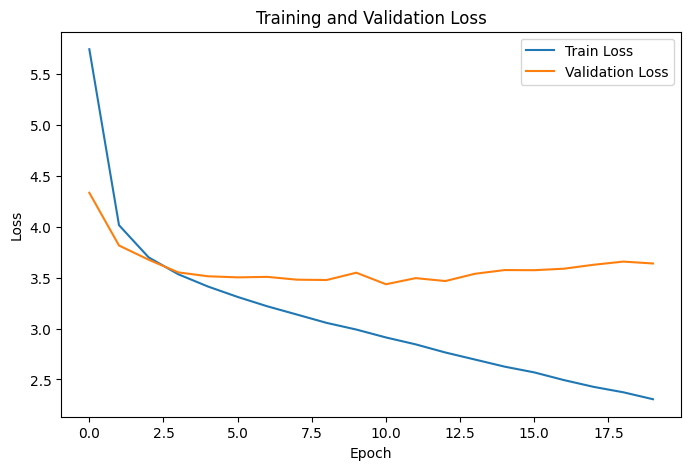

In [15]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### Задание 4. Оценка качества на задаче классификации аудио (2 балла)


Теперь нужно понять, насколько хорошо аудио-векторы после проекции "попадают" в пространство текстовых эмбеддингов:

1. Посчитайте проекции аудио для всех примеров в валидации.
2. Для каждого аудио найдите `top-k` наиболее похожих текстов по косинусному сходству (или скалярному произведению после L2-нормализации).
3. Посчитайте `accuracy@1`, `accuracy@3`, `accuracy@10`, т.е. долю случаев, когда "правильный" текст попал в топ-k.
4. Сравните с неким *случайным бейзлайном*: для каждого аудио выберите `k` случайных текстов и посчитайте такую же метрику.

> Важно: в батче класс "правильного" текста для i-го аудио - это индекс i (как в контрастивном лоссе).

In [ ]:
# your code here
# (⌐■_■)

In [16]:
audio_proj.load_state_dict(best_model_state["audio_proj"])
text_proj.load_state_dict(best_model_state["text_proj"])

audio_proj.eval()
text_proj.eval()

ProjectionModule(
  (projection): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [18]:
topk_list = [1, 3, 10]

all_audio = []
all_text = []

with torch.no_grad():
    for audio_emb, text_emb in test_loader:
        audio_emb = audio_emb.float().to(device)
        text_emb = text_emb.float().to(device)
        all_audio.append(audio_proj(audio_emb))
        all_text.append(text_proj(text_emb))

all_audio = torch.cat(all_audio, dim=0)
all_text = torch.cat(all_text, dim=0)

all_audio = F.normalize(all_audio, p=2, dim=1)
all_text = F.normalize(all_text, p=2, dim=1)

similarity = all_audio @ all_text.T
N = all_audio.size(0)

metrics = {f"acc@{k}": 0 for k in topk_list}
random_metrics = {f"acc@{k}": 0 for k in topk_list}

for i in range(N):
    sorted_idx = similarity[i].argsort(descending=True)
    for k in topk_list:
        kk = k if k <= N else N
        topk = sorted_idx[:kk].tolist()
        if i in topk:
            metrics[f"acc@{k}"] += 1
        random_topk = random.sample(range(N), kk)
        if i in random_topk:
            random_metrics[f"acc@{k}"] += 1

for k in topk_list:
    metrics[f"acc@{k}"] /= N
    random_metrics[f"acc@{k}"] /= N

print("=== Solution Accuracy ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Random Baseline ===")
for k, v in random_metrics.items():
    print(f"{k}: {v:.4f}")


=== Solution Accuracy ===
acc@1: 0.1620
acc@3: 0.3541
acc@10: 0.6324

=== Random Baseline ===
acc@1: 0.0010
acc@3: 0.0042
acc@10: 0.0093


### Вывод

Оформите, пожалуйста, небольшой вывод. Например, можно воспрользоваться следующим планом:

   * какую аудио-модель вы выбрали и почему;
   * как вели себя потери на обучении;
   * какие значения метрик получились и насколько они превосходят случайный baseline;
   * любые наблюдения (например, зависимость от числа эпох, размера батча и т.д.);
   * милые пожелания ассистенту/лектору, который будет это проверять.

your text here (ಠ.ಠ)

## Вывод по проделанной работе

**Выбор аудио-модели:**  
Выбрана модель **CNN14**, так как она позволяет быстро вычислять эмбеддинги для аудио. Изначально пробовалась **wav2vec2**, но из-за долгого времени обработки было принято решение использовать более лёгкую и быструю модель.

**Поведение потерь во время обучения:**  
Обучение велось на 20 эпох. Потери на обучении постепенно падали на протяжении всех эпох. На валидационной выборке лосс снижался до 11-й эпохи, после чего начал расти, что указывает на начало переобучения. Для предотвращения проблем с оверфитом был сохранён лучший чекпоинт по минимальному валидационному лоссу.

**Значения метрик и сравнение с baseline:**  
Метрики на тестовом наборе:  
- **acc@1:** 0.1620  
- **acc@3:** 0.3541  
- **acc@10:** 0.6324  

Случайный бейзлайн:  
- **acc@1:** 0.0010  
- **acc@3:** 0.0042  
- **acc@10:** 0.0093  

Метрики модели значительно превосходят случайный baseline.

**Наблюдения и эксперименты:**  
- Переобучение стало заметно после 11-й эпохи: лосс на обучении продолжал падать, а на валидации — расти.  
- Сравнение методов: использование **SigLIP** дало метрики примерно в 2 раза лучше, чем классический CLIP.  
- Решил также добавить проекцию и для текстовых эмбеддингов, чтобы их тоже адаптировать под общее латентное пространство.

**Пожелания ассистенту/лектору:**  
Очень крутые лекции и домашки, спасибо большое!